<a href="https://colab.research.google.com/github/miquelt9/data-science-jobbarcelona23/blob/main/DataChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Statement

➡️ Contexto:

Somos un banco que dispone de una base de datos con una gran cantidad de información sobre nuestros clientes. Nuestro objetivo es ayudar a los analistas a predecir la tasa de abandono de estos clientes para así poder reducirla. La base de datos incluye información demográfica como la edad, el sexo, el estado civil y la categoría de ingresos. También contiene información sobre el tipo de tarjeta, el número de meses en cartera y los periodos inactivos. Además, dispone de datos clave sobre el comportamiento de gasto de los clientes que se acercan a su decisión de cancelación. Entre esta última información hay el saldo total renovable, el límite de crédito, la tasa media de apertura a la compra y métricas analizables como el importe total del cambio del cuarto trimestre al primero o el índice medio de utilización.

Frente a este conjunto de datos podemos capturar información actualizada que puede determinar la estabilidad de la cuenta a largo plazo o su salida inminente.

📄 Dataset: [supply_chain_train.csv]()

Para este desafío, tendrás que predecir el Attrition_Flag.

🎯 Objetivo:

Crea un modelo predictivo de clasificación para poder clasificar los datos del archivo de [testing](). Primero entrena tu modelo con el conjunto de datos de training y una vez que tengas el modelo que maximice la puntuación f1 (macro.) utiliza los datos de testing como entrada para tu modelo.

#Dependencies imports and data treatment

0️⃣ - First of all we have to make sure our libraries are installed:

In [ ]:
pip install pandas numpy keras tensorflow

1️⃣ - 📚 Import the libraries we will use for creating the model and load the training data file

In [49]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Configure libraries
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')


# Load dataset
df_bank = pd.read_csv('https://raw.githubusercontent.com/miquelt9/data-science-jobbarcelona23/main/supply_chain_train.csv')

2️⃣ - ✨ Get the data ready by applying transformations

In [50]:
def my_map(df, df_col):
  mapping = {val: i for i, val in enumerate(set(df[df_col]))}
  df[df_col] = [mapping[val] for val in df[df_col]]

def my_transformation(df):

  scaler = StandardScaler()
  num_cols = ['Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

  # df[num_cols] = scaler.fit_transform(df[num_cols])

  df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'F' else 0)

  my_map(df, 'Education_Level')
  my_map(df, 'Marital_Status')
  my_map(df, 'Income_Category')
  my_map(df, 'Card_Category')
  for col in df:
    df[col] = list(map(int, df[col]))

  return df


In [68]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Copying original dataframe
df_bank_ready = df_bank.copy()

df_bank_ready = df_bank_ready.drop('train_idx', axis=1)
df_bank_ready = df_bank_ready.drop('CLIENTNUM', axis=1)

df_bank_ready = my_transformation(df_bank_ready)

print('Shape of dataframe:', df_bank_ready.shape)
df_bank_ready.head()

df_bank_ready['Attrition_Flag'].value_counts()


Shape of dataframe: (8101, 20)


1    6801
0    1300
Name: Attrition_Flag, dtype: int64

🖖 Splitting data for training and testing

In [52]:
# Select Features
feature = df_bank_ready.drop('Attrition_Flag', axis=1)

# Select Target
target = df_bank_ready['Attrition_Flag']

# Set Training and Testing Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)

# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (6480, 19)
Shape of testing feature: (1621, 19)
Shape of training label: (6480,)
Shape of training label: (1621,)


💾 Save the prepared data

In [40]:
from joblib import dump, load
from sklearn.model_selection import train_test_split

# Saving model and loading model
if 'feature' in globals():
  dump(feature, 'feature.data')
  dump(target, 'target.data')
else:
  feature = load('feature.data') 
  target = load('target.data') 

X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                  shuffle = True, 
                                                  test_size=0.2, 
                                                  random_state=1)

#Model evaluation

3️⃣ - Evaluation models (will use this function to check how good a model is)

In [53]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

4️⃣ - Building the clasification models

##Tree Decision 🌳 

In [54]:
from sklearn import tree

# Building Decision Tree model 
dtc = tree.DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# # Evaluate Model
dtc_eval = evaluate_model(dtc, X_test, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Cohens Kappa Score:', dtc_eval['kappa'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

Accuracy: 0.9302899444787168
Precision: 0.9536423841059603
Recall: 0.962852897473997
F1 Score: 0.9582255083179297
Cohens Kappa Score: 0.747826541864624
Area Under Curve: 0.8668809941915441
Confusion Matrix:
 [[ 212   63]
 [  50 1296]]


##Random Forest 🌲🌲🌲

In [69]:
from sklearn.ensemble import RandomForestClassifier

# Building Random Forest model 
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Evaluate Model
rf_eval = evaluate_model(rf, X_test, y_test)

# Print result
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Cohens Kappa Score:', rf_eval['kappa'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Accuracy: 0.9537322640345466
Precision: 0.9581831290555155
Recall: 0.987369985141159
F1 Score: 0.9725576289791438
Cohens Kappa Score: 0.825420849553913
Area Under Curve: 0.9807591516952586
Confusion Matrix:
 [[ 217   58]
 [  17 1329]]


##Naive Bayes 📊

In [25]:
from sklearn.naive_bayes import GaussianNB

# Building Naive Bayes model 
nb = GaussianNB()
nb.fit(X_train, y_train)

# Evaluate Model
nb_eval = evaluate_model(nb, X_test, y_test)

# Print result
print('Accuracy:', nb_eval['acc'])
print('Precision:', nb_eval['prec'])
print('Recall:', nb_eval['rec'])
print('F1 Score:', nb_eval['f1'])
print('Cohens Kappa Score:', nb_eval['kappa'])
print('Area Under Curve:', nb_eval['auc'])
print('Confusion Matrix:\n', nb_eval['cm'])

Accuracy: 0.8809376927822332
Precision: 0.924834193072955
Recall: 0.9323922734026746
F1 Score: 0.9285978542360341
Cohens Kappa Score: 0.5705630189466575
Area Under Curve: 0.8672592192354451
Confusion Matrix:
 [[ 173  102]
 [  91 1255]]


##K-Nearest Neighbours 🏘️

In [26]:
from sklearn.neighbors import KNeighborsClassifier

# Building KNN model 
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Evaluate Model
knn_eval = evaluate_model(knn, X_test, y_test)

# Print result
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Cohens Kappa Score:', knn_eval['kappa'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy: 0.8846391116594695
Precision: 0.9154121863799283
Recall: 0.9487369985141159
F1 Score: 0.931776723823422
Cohens Kappa Score: 0.5592937697453262
Area Under Curve: 0.8756179927056599
Confusion Matrix:
 [[ 157  118]
 [  69 1277]]


💾 Save the models

In [72]:
from joblib import dump, load

# Saving model
dump(dtc, 'bank_client_prediction_dtc.joblib')
dump(rf, 'bank_client_prediction_rf.joblib')
dump(nb, 'bank_client_prediction_nb.joblib')
dump(knn, 'bank_client_prediction_knn.joblib')

# Loading model
dtc = load('bank_client_prediction_dtc.joblib') 
rf  = load('bank_client_prediction_rf.joblib') 
nb  = load('bank_client_prediction_nb.joblib') 
knn = load('bank_client_prediction_knn.joblib') 

#Model comparison 📊

5️⃣ - Statistics plotted
(Random Forest was not done because of the amount of time was taking to fit the model)

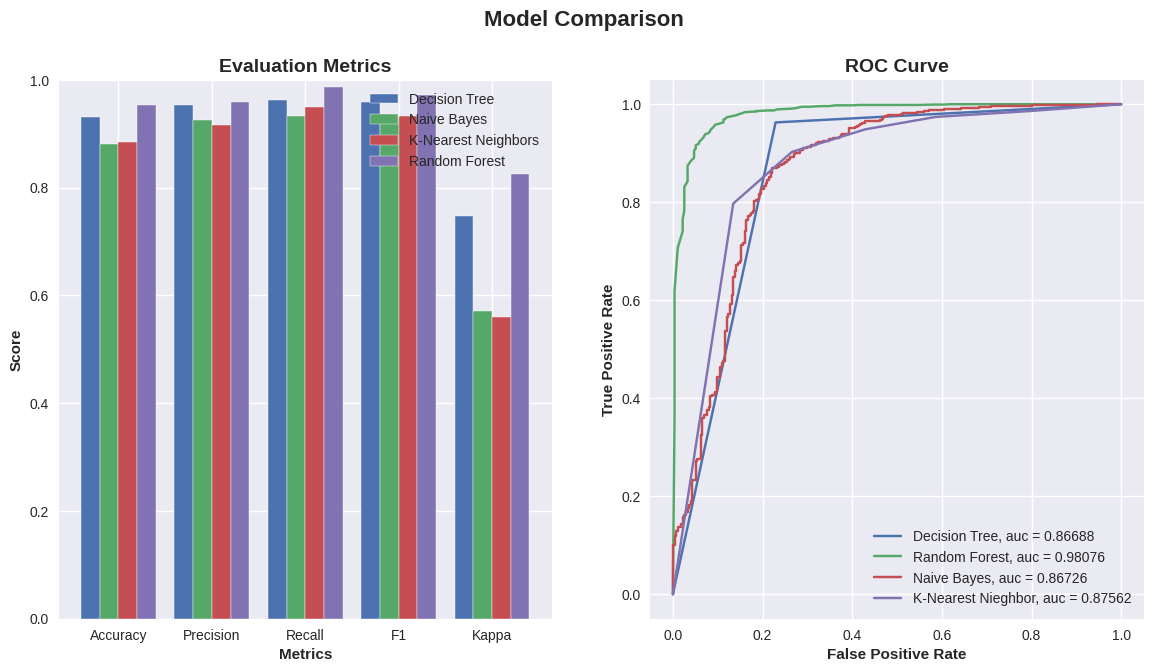

In [70]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1'], dtc_eval['kappa']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
nb_score = [nb_eval['acc'], nb_eval['prec'], nb_eval['rec'], nb_eval['f1'], nb_eval['kappa']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1'], knn_eval['kappa']]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

## Make the plot
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes')
ax1.bar(r3, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')
ax1.bar(r4, rf_score, width=barWidth, edgecolor='white', label='Random Forest')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(nb_eval['fpr'], nb_eval['tpr'], label='Naive Bayes, auc = {:0.5f}'.format(nb_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

#Model omptimitzation 📈

6️⃣ - (Will optimize the Random Forest since is the one which already has good f1 score)

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [50, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500]
}

# Create a base model
dt_grids = RandomForestClassifier(random_state=0)

# Initiate the grid search model
grid_search = GridSearchCV(estimator=dt_grids, param_grid=param_grid, scoring='f1', #f1 is the one we want to maximize
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


{'max_depth': 50,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [78]:
# Select best model with best fit
best_grid = grid_search.best_estimator_

# Evaluate Model
best_grid_eval = evaluate_model(best_grid, X_test, y_test)

# Print result
print('Accuracy:', best_grid_eval['acc'])
print('Precision:', best_grid_eval['prec'])
print('Recall:', best_grid_eval['rec'])
print('F1 Score:', best_grid_eval['f1'])
print('Cohens Kappa Score:', best_grid_eval['kappa'])
print('Area Under Curve:', best_grid_eval['auc'])
print('Confusion Matrix:\n', best_grid_eval['cm'])

Accuracy: 0.9512646514497224
Precision: 0.9554277498202732
Recall: 0.987369985141159
F1 Score: 0.9711362805991962
Cohens Kappa Score: 0.8149717167192839
Area Under Curve: 0.9806997163312171
Confusion Matrix:
 [[ 213   62]
 [  17 1329]]


💾 Save the optimized model

In [79]:
from joblib import dump, load

# Saving model
dump(best_grid, 'bank_client_prediction_opt.joblib')

# Loading model
best_grid = load('bank_client_prediction_opt.joblib')

📊 Model comparasion Non-Optimized vs Optimized Model

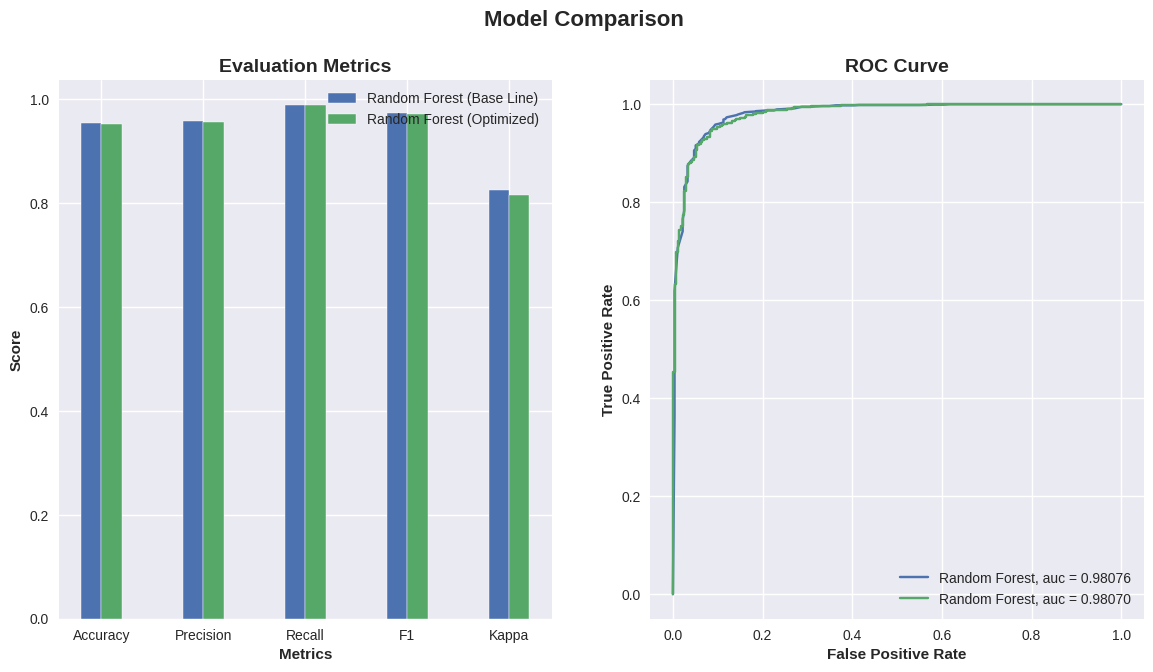

Change of -0.26% on accuracy.
Change of -0.29% on precision.
Change of 0.00% on recall.
Change of -0.15% on F1 score.
Change of -1.27% on Kappa score.
Change of -0.01% on AUC.


In [80]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
best_grid_score = [best_grid_eval['acc'], best_grid_eval['prec'], best_grid_eval['rec'], best_grid_eval['f1'], best_grid_eval['kappa']]

## Set position of bar on X axis
r1 = np.arange(len(rf_score))
r2 = [x + barWidth for x in r1]

## Make the plot
ax1.bar(r1, rf_score, width=barWidth, edgecolor='white', label='Random Forest (Base Line)')
ax1.bar(r2, best_grid_score, width=barWidth, edgecolor='white', label='Random Forest (Optimized)')

## Add xticks on the middle of the group bars
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 0.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
# ax1.set_ylim(0, 1)

## Create legend & Show graphic
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(best_grid_eval['fpr'], best_grid_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(best_grid_eval['auc']))

ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.legend(loc=4)

plt.show()

print('Change of {:0.2f}% on accuracy.'.format(100 * ((best_grid_eval['acc'] - rf_eval['acc']) / rf_eval['acc'])))
print('Change of {:0.2f}% on precision.'.format(100 * ((best_grid_eval['prec'] - rf_eval['prec']) / rf_eval['prec'])))
print('Change of {:0.2f}% on recall.'.format(100 * ((best_grid_eval['rec'] - rf_eval['rec']) / rf_eval['rec'])))
print('Change of {:0.2f}% on F1 score.'.format(100 * ((best_grid_eval['f1'] - rf_eval['f1']) / rf_eval['f1'])))
print('Change of {:0.2f}% on Kappa score.'.format(100 * ((best_grid_eval['kappa'] - rf_eval['kappa']) / rf_eval['kappa'])))
print('Change of {:0.2f}% on AUC.'.format(100 * ((best_grid_eval['auc'] - rf_eval['auc']) / rf_eval['auc'])))

#Solution generation

Load testing file:

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import utils

# Load dataset
df_bank_test = pd.read_csv('https://raw.githubusercontent.com/miquelt9/data-science-jobbarcelona23/main/supply_chain_test.csv')

df_bank_test = df_bank_test.drop('test_idx', axis=1)
df_bank_test = df_bank_test.drop('CLIENTNUM', axis=1)

df_bank_test = my_transformation(df_bank_test)

# Select Features
test_feature = df_bank_test

print('Shape of dataframe:', df_bank_test.shape)
df_bank_test.head()

Shape of dataframe: (2026, 19)


,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,48,1,3,4,3,2,3,39,4,3,4,2991,1508,1483,0,3734,64,0,0
1,59,0,1,4,3,2,3,53,5,5,4,2192,1569,623,0,4010,79,0,0
2,37,1,2,5,1,2,3,36,4,3,3,1734,987,747,0,4727,67,0,0
3,47,0,3,3,1,4,3,36,4,2,3,4786,1516,3270,0,4973,74,0,0
4,42,0,3,2,3,3,3,33,3,3,2,3714,2170,1544,0,1454,35,0,0


In [83]:
#df_bank_test = dtc.predict(test_feature)
df_bank_test = rf.predict(test_feature)
#df_bank_test = best_grid.predict(test_feature) # the optimitzation in fact decreased by 15% the f1 score

# Save new dataframe into csv file
df = pd.DataFrame(df_bank_test)
df.columns = ['target']
df.to_csv('predictions.csv', index=False)

df = pd.read_csv(r'predictions.csv')
df.to_json (r'predictions.json')

df.head(8)
df['target'].value_counts()

1    1749
0     277
Name: target, dtype: int64